In [1]:
# conda: xesmfTools

In [2]:
# This is the same as Example#4 except that it uses dask for
# array manipulation to keep the memory footprint down.

# In this example, we recreate the polar sterographic IBCAO grid.
# Part A: outside the gridtools library
# Part B: using the gridtools library
# IBCAO grid details
# Cartesian grid
#   dx: 2500 meters
#   dy: 2500 meters
# Grid extent:
#   X: -2902500 to 2902500
#   Y: -2902500 to 2902500
#
# Projection
#   Stereographic
#   lat_0=90.0 (latitude of projection center)
#   lat_ts=75.0 (latitude where scale is not distorted)
#   lon_0 (not specified, at lat_0=90 it can be any value, proj defaults to 0.0)

# For proper orientation for plotting to match the IBCAO technical manual
# please use lon_0=0.0 for a plotting parameter.

# Example 5 is a python script that is similar to this notebook.
# Example 5a is the same example but using a slightly different earth radius.

# Part A: Compute the grid ourselves

In [3]:
import numpy as np
import xarray as xr
import dask.array as da

In [4]:
# IBCAO
# Working in cartesian coordinates, all values are in meters
# NOTE: To create a true MOM6 supergrid, the cell spacing
# is half the length of a full grid cell.
dx = 2500. / 2.
dy = 2500. / 2.
x = da.arange(-2902500., 2902500. + dx, dx, dtype=np.float32, chunks = (100))
y = da.arange(-2902500., 2902500. + dy, dy, dtype=np.float32, chunks = (100))

In [5]:
# This is the grid size
x.shape, y.shape

((4645,), (4645,))

In [6]:
# Create cartesian grid (y, x)
# Confirm grid points and x, y coordinates

In [7]:
yy, xx = da.meshgrid(y, x)

In [8]:
# From the command line we can convert single points
# gdaltransform -s_srs "+ellps=WGS84 +proj=stere +lat_0=90 +lat_ts=75" -t_srs EPSG:4326
# The pyproj library provides for 2D array transformation of coordinates.

from pyproj import CRS, Transformer

PROJSTRING = "+proj=stere +lat_0=90 +lat_ts=75 +ellps=WGS84"

# create the coordinate reference system
crs = CRS.from_proj4(PROJSTRING)
# create the projection from lon/lat to x/y
proj = Transformer.from_crs(crs.geodetic_crs, crs)

# compute the lon/lat
# ORIGINAL
#lon, lat = proj.transform(yy, xx, direction='INVERSE')

# DASK
def gufoo(yy, xx):
    return proj.transform(yy, xx, direction='INVERSE')
lon, lat = da.apply_gufunc(gufoo, "(i),(j)->(i),(j)", yy, xx, vectorize=True, allow_rechunk=True)

/home/cermak/miniconda3/envs/xesmfTools/lib/python3.7/site-packages/dask/array/gufunc.py:430: PerformanceWarning: Increasing number of chunks by factor of 47
  func, loop_output_dims, *arginds, concatenate=True, **kwargs


In [9]:
# Confirm we have the correct grid points and lat lon values
print(float(yy[0,0]), float(xx[0,0]), float(lat[0,0]), float(lon[0,0]))
print(float(yy[y.shape[0]-1, x.shape[0]-1]), float(xx[y.shape[0]-1, x.shape[0]-1]), float(lat[y.shape[0]-1, x.shape[0]-1]), float(lon[y.shape[0]-1, x.shape[0]-1]))

-2902500.0 -2902500.0 53.8170746379705 -45.0
2902500.0 2902500.0 53.8170746379705 135.0


In [10]:
import os, sys
sys.path.append('lib')
from gridutils import GridUtils

In [11]:
grd = GridUtils()

In [12]:
grd.clearGrid()

In [13]:
# Define IBCAO grid for gridtools library
grd.setGridParameters({
    'projection': {
        'name': "Stereographic",
        'ellps': 'WGS84',
        'lon_0': 0.0,
        'lat_0': 90.0,
        'lat_ts': 75.0,
        'dx': 5000.0,
        'dy': 5000.0,
        'dxUnits': 'meters',
        'dxUnits': 'meters'
    }
})
grd.grid['x'] = (('nyp','nxp'), lon)
grd.grid['y'] = (('nyp','nxp'), lat)

In [14]:
grd.grid

<xarray.Dataset>
Dimensions:  (nxp: 4645, nyp: 4645)
Dimensions without coordinates: nxp, nyp
Data variables:
    x        (nyp, nxp) float64 dask.array<chunksize=(100, 4645), meta=np.ndarray>
    y        (nyp, nxp) float64 dask.array<chunksize=(100, 4645), meta=np.ndarray>

In [15]:
grd.setPlotParameters(
    {
        'figsize': (8,8),
        'projection': {
            'name': 'Stereographic',    
            'lon_0': 0.0,
            'lat_0': 90.0
        },
        'extent': [-180, 180, 60, 90],
        'iLinewidth': 1,
        'jLinewidth': 1,
        'showGrid': True,
        'title': 'Stereographic: IBCAO',
        'iColor': 'k',
        'jColor': 'k'
    }
)

In [16]:
(figure, axes) = grd.plotGrid()

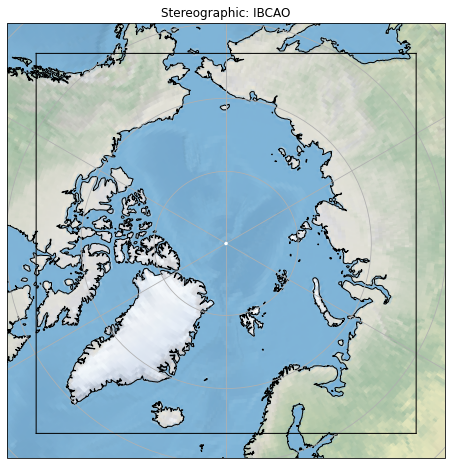

In [17]:
figure

In [18]:
# Compute grid metrics
grd.computeGridMetrics()

In [19]:
grd.grid

<xarray.Dataset>
Dimensions:   (nx: 4644, nxp: 4645, ny: 4644, nyp: 4645)
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    x         (nyp, nxp) float64 dask.array<chunksize=(100, 4645), meta=np.ndarray>
    y         (nyp, nxp) float64 dask.array<chunksize=(100, 4645), meta=np.ndarray>
    dx        (nyp, nx) float64 1.148e+03 1.148e+03 ... 1.148e+03 1.148e+03
    dy        (ny, nxp) float64 1.148e+03 1.148e+03 ... 1.148e+03 1.148e+03
    angle_dx  (nyp, nxp) float64 0.7864 0.7864 0.7861 ... -2.355 -2.355 -2.355
    area      (ny, nx) float64 1.318e+06 1.318e+06 ... 1.318e+06 1.318e+06
Attributes:
    grid_version:  0.2
    code_version:  GridTools: 0.1
    history:       2021-05-06 19:58:34: created grid with GridTools library
    projection:    Stereographic
    proj:          +ellps=WGS84 +proj=stere +lat_0=90.0 +lon_0=0.0 +lat_ts=75...

# Part B: Use the gridtools library

In [20]:
# Clear the grid and plot parameters
grd.clearGrid()

In [21]:
# From the technical documentation, we know:
#  * the center point,
#  * the grid extent
#  * the grid resolution
#  * the projection: standard ellipse and polar projection
#  * the latitude of true scale
#
# The full size of the grid is 2902500 + 2902500 meters (5805000 meters)
# North Pole: lat_0 = 90.0
# Latitude of true scale: lat_ts = 75.0
grd.setGridParameters({
    'projection': {
        'name': "Stereographic",
        'ellps': 'WGS84',
        'lon_0': 0.0,
        'lat_0': 90.0,
        'lat_ts': 75.0,
    },
    'centerX': 0.0,
    'centerY': 90.0,
    'cneterUnits': 'degrees',
    'dx': 5805000.0,
    'dy': 5805000.0,
    'dxUnits': 'meters',
    'dyUnits': 'meters',
    'gridResolution': 2500.0,
    'gridResolutionUnits': 'meters',
    'tilt': 0.0,
    'gridMode': 2,
    'gridType': 'MOM6',
    'ensureEvenI': True,
    'ensureEvenJ': True
})

In [22]:
grd.makeGrid()

Transformation proj string(+proj=stere +lat_0=90.000000 +lat_ts=75.000000 +ellps=WGS84)
Computing center point in meters: (90.000000, 0.000000) to (0.000000, 0.000000)


In [23]:
grd.grid

<xarray.Dataset>
Dimensions:   (nx: 4644, nxp: 4645, ny: 4644, nyp: 4645)
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    x         (nyp, nxp) float64 -45.0 -44.99 -44.98 ... 135.0 135.0 135.0
    y         (nyp, nxp) float64 53.82 53.82 53.83 53.84 ... 53.83 53.82 53.82
    dx        (nyp, nx) float64 1.148e+03 1.148e+03 ... 1.148e+03 1.148e+03
    dy        (ny, nxp) float64 1.148e+03 1.148e+03 ... 1.148e+03 1.148e+03
    angle_dx  (nyp, nxp) float64 0.7864 0.7864 0.7861 ... -2.355 -2.355 -2.355
    area      (ny, nx) float64 1.318e+06 1.318e+06 ... 1.318e+06 1.318e+06
Attributes:
    grid_version:  0.2
    code_version:  GridTools: 0.1
    history:       2021-05-06 20:01:39: created grid with GridTools library
    projection:    Stereographic
    proj:          +ellps=WGS84 +proj=stere +lat_0=90.0 +lon_0=0.0 +lat_ts=75...

In [24]:
grd.setPlotParameters(
    {
        'figsize': (8,8),
        'projection': {
            'name': 'Stereographic',    
            'lon_0': 0.0,
            'lat_0': 90.0
        },
        'extent': [-180, 180, 60, 90],
        'iLinewidth': 1,
        'jLinewidth': 1,
        'showGrid': True,
        'title': 'Stereographic: IBCAO',
        'iColor': 'k',
        'jColor': 'k'
    }
)

In [25]:
(figure, axes) = grd.plotGrid()

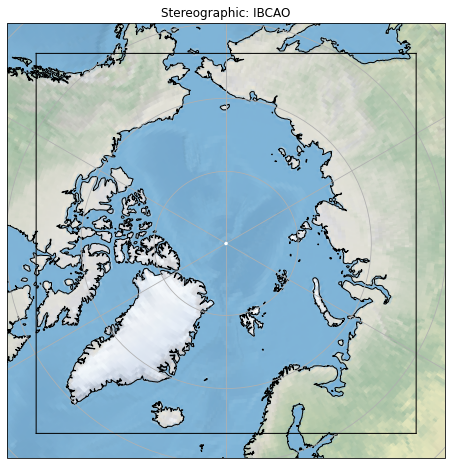

In [26]:
figure